In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [78]:
data_path = "../Training Project Data v0.1/"

# Task 1. Figure out all possible event types.

In [79]:
events_records = []

with open(data_path + "events.jsonl", 'r') as f:
    for line in f:
        record = json.loads(line)
        if "events" in record:
            for event in record["events"]:
                if "tags" in event:
                    event["tags"] = ",".join(event["tags"])
                events_records.append(event)
        else:
            if "tags" in record:
                record["tags"] = ",".join(record["tags"])
            events_records.append(record)

events_df = pd.DataFrame.from_records(events_records)


In [80]:
events_df = events_df.drop_duplicates()

In [81]:
events_df.head()

,user_id,video_id,event,timestamp,tags,comment
0,1,100,created,1642663347,"cute,duck,animals",NaN
1,4,100,like,1642943347,NaN,NaN
2,2,100,like,1642953347,NaN,NaN
3,2,100,commented,1642954347,NaN,"oh, it's so cute!!!!"
4,3,100,commented,1642964347,NaN,I will buy my own


In [82]:
#All possible event types
events_df.event.unique()

array(['created', 'like', 'commented', 'add_tags', 'remove_tags'],
      dtype=object)

# Task 2. Visualize videos like rate (likes count to time dashboard).

In [83]:
likes_event_df = events_df[events_df["event"] == "like"]

In [84]:
likes_event_df.head()

,user_id,video_id,event,timestamp,tags,comment
1,4,100,like,1642943347,NaN,NaN
2,2,100,like,1642953347,NaN,NaN
6,5,100,like,1642994347,NaN,NaN
7,6,100,like,1642998347,NaN,NaN
11,0,101,like,1642690000,NaN,NaN


<AxesSubplot:xlabel='timestamp', ylabel='count'>

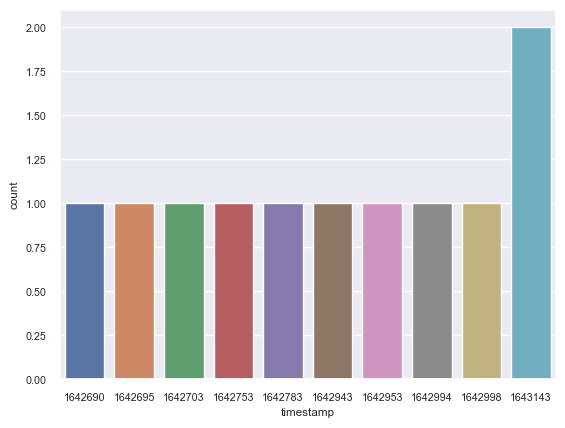

In [85]:
sns.set(font_scale=0.7)
sns.countplot(x=likes_event_df["timestamp"] // 1000)

# Task 3. 

Figure out how often each person views videos with at least one tag that is the same as one from user categories

1. Getting all the videos with its tags by using "created" and "add_tags" events

In [338]:
created_events_df = events_df[events_df["event"] == "created"]
video_tag_df = created_events_df[["video_id", "tags"]]

In [339]:
add_tags_events_df = events_df[events_df["event"] == "add_tags"]
add_tag_df = add_tags_events_df[["video_id", "tags"]]

In [340]:
video_tag_df = video_tag_df.merge(add_tag, on="video_id", how='left')
video_tag_df = video_tag_df.fillna("")

In [341]:
video_tag_df["tags_x"] = video_tag_df["tags_x"] + "," + video_tag_df["tags_y"]

In [342]:
video_tag_df = video_tag_df.drop(["tags_y"], axis=1)
video_tag_df = video_tag_df.rename(columns={"tags_x": "tags"})
video_tag_df

,video_id,tags
0,100,"cute,duck,animals,food"
1,101,"travel,bicycle,mountains,"


2. Knowing "liked" events we can find which videos each user watched and then exclude uder-video pair if he is an author of this video.

In [343]:
user_video_df = likes_event_df[["user_id", "video_id"]]

In [344]:
user_created_df = created_events_df[["user_id", "video_id"]]

In [346]:
user_video_df.head()

,user_id,video_id
1,4,100
2,2,100
6,5,100
7,6,100
11,0,101


In [347]:
user_video_df = pd.merge(user_video_df, user_created_df, on=['user_id','video_id'], how="outer", indicator=True)
user_video_df = user_video_df[user_video_df['_merge'] == 'left_only']

In [348]:
user_video_df = user_video_df.drop(["_merge"], axis=1)

User-video dataframe without videos which user created by himself.

In [349]:
user_video_df.head()

,user_id,video_id
0,4,100
1,2,100
2,5,100
3,6,100
4,0,101


3. From csv file we create user-category dataframe to have users preferred categories

In [350]:
users_df = pd.read_csv(data_path + "users.csv")
users_df_11 = pd.read_csv(data_path + "users-011.csv")
users_df = pd.concat([users_df, users_df_11])
users_df = users_df.drop_duplicates()
user_categories_df = users_df[["id", "categories"]]
user_categories_df = user_categories_df.rename(columns={"id": "user_id"})

In [351]:
user_categories_df.head()

,user_id,categories
0,0,animals;duck;cute;travel
1,1,animals;duck;bicycle
2,2,duck;cute;bicycle
3,3,animals;cute;travel;bicycle;mountains
4,4,animals;duck


4. Merge user-category df with user-video to add video which user watched and then merge it with video_tag to add tags of these videos.

In [352]:
user_categories_df = user_categories_df.merge(user_video_df, on='user_id', how='left')

In [353]:
user_categories_df = user_categories_df[user_categories_df["video_id"].notna()]
user_categories_df.head()

,user_id,categories,video_id
0,0,animals;duck;cute;travel,101.0
1,1,animals;duck;bicycle,101.0
2,2,duck;cute;bicycle,100.0
4,4,animals;duck,100.0
5,4,animals;duck,101.0


In [354]:
user_categories_df = user_categories_df.merge(video_tag_df, on="video_id", how='left')
user_categories_df = user_categories_df[user_categories_df["tags"].notna()]

In [355]:
user_categories_df.head()

,user_id,categories,video_id,tags
0,0,animals;duck;cute;travel,101.0,"travel,bicycle,mountains,"
1,1,animals;duck;bicycle,101.0,"travel,bicycle,mountains,"
2,2,duck;cute;bicycle,100.0,"cute,duck,animals,food"
3,4,animals;duck,100.0,"cute,duck,animals,food"
4,4,animals;duck,101.0,"travel,bicycle,mountains,"


5. As final step we are adding same_as_cat column to know either user watched video with preferred tag or not and then grouping df by user_id to count total number of preferred/not preferred videos.

In [356]:
def is_interested_in_tags(row):
    res = 0
    for cat in row["categories"].split(';'):
        if cat in row["tags"]:
            res = 1
    return res

In [357]:
user_categories_df["same_as_cat"] = user_categories_df.apply(lambda row: is_interested_in_tags(row), axis=1)
user_categories_df = user_categories_df[["user_id", "same_as_cat"]]

In [358]:
user_categories_df.head()

,user_id,same_as_cat
0,0,1
1,1,1
2,2,1
3,4,1
4,4,0


In [359]:
df_count_same_as_cat = user_categories_df.groupby('user_id')['same_as_cat'].apply(lambda x: (x==1).sum()).reset_index(name='count_same')
df_count_diff_from_cat = user_categories_df.groupby('user_id')['same_as_cat'].apply(lambda x: (x==0).sum()).reset_index(name='count_diff')

In [360]:
df_count_same_as_cat.head

,user_id,count_same
0,0,1
1,1,1
2,2,2
3,4,1
4,5,1
5,6,2
6,7,1


In [361]:
df_count_diff_from_cat

,user_id,count_diff
0,0,0
1,1,0
2,2,0
3,4,1
4,5,1
5,6,0
6,7,0


Final dataframe

In [362]:
df_count_same_as_cat = df_count_same_as_cat.join(df_count_diff_from_cat["count_diff"])
df_count_same_as_cat

,user_id,count_same,count_diff
0,0,1,0
1,1,1,0
2,2,2,0
3,4,1,1
4,5,1,1
5,6,2,0
6,7,1,0


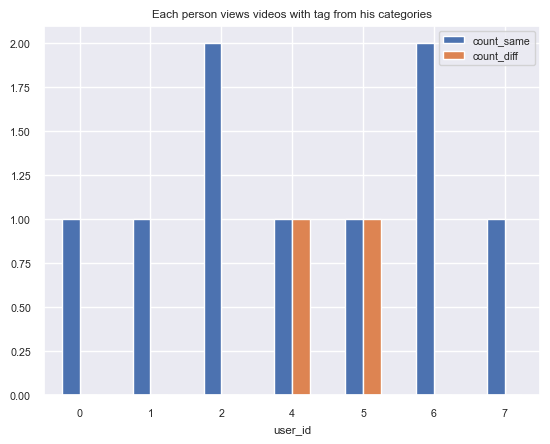

In [365]:
df_count_same_as_cat.plot(x="user_id", y=["count_same", "count_diff"], kind="bar", rot=0, title='Each person views videos with tag from his categories')
plt.show()